<a href="https://colab.research.google.com/github/josephmhernandez/SeizureDetection/blob/master/SeizureDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Data

## openPose

In [0]:
#Load Open Pose
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`


Selecting previously unselected package libgflags2.2.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../00-libgflags2.2_2.2.1-1_amd64.deb ...
Unpacking libgflags2.2 (2.2.1-1) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../01-libgflags-dev_2.2.1-1_amd64.deb ...
Unpacking libgflags-dev (2.2.1-1) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../02-libgoogle-glog0v5_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.3.5-1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to unpack .../03-libgoogle-glog-dev_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog-dev (0.3.5-1) ...
Selecting previously unselected package libhdf5-serial-dev.
Preparing to unpack .../04-libhdf5-serial-dev_1.10.0-patch1+docs-4_all.deb ...
Unpacking libhdf5-serial-dev (1.10.0-patch1+docs-4) ...
Selecting previously unselected package libleveldb1v5:amd64.
Preparing to unpack ...

### Creating action landmarks

In [0]:
#Connect to Google Drive.

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#Function: save video in colab memory 
!pip install youtube_dl
!pip install pafy

import youtube_dl
import os
import pafy
import numpy as np

def create_vid(link):
    ydl = youtube_dl.YoutubeDL({'outtmpl': '%(id)s%(ext)s',
            'noplaylist' : True})
    link_video = link
    with ydl:
        result = ydl.extract_info(
            link_video,
            download=True
        )

    if 'entries' in result:
        # Can be a playlist or a list of videos
        video = result['entries'][0]
    else:
        # Just a video
        video = result

    title = video['id']

    file_list = np.array(os.listdir(path=None))
    video_name = None
    for a in file_list:
        if(title in a):
            print('here')
            video_name = a
            break

    nvideo = pafy.new(link_video)
    video_duration=nvideo.length 

    os.rename(video_name, nvideo.title + '.' + video['ext'])
    video_name = nvideo.title + '.' + video['ext']
    title = nvideo.title
    return video_name, title

In [0]:
# Function
# Iterate through JSON files of a video and save every 120 as an npy file. 
import json
import numpy as np
import os
def create_120_npy_from_vid_json(read_json_folder, write_folder, save_name):
    newJsonOutput = read_json_folder
    print('Change JSON files to npy files....')
    jsonFiles = np.array(os.listdir(newJsonOutput))
    jsonFiles.sort()

    rtnList = np.zeros((len(jsonFiles),50)) 

    print(len(jsonFiles))
    print('total npy outputs: ' + str(len(jsonFiles) // 120))

    for i,jsonFile in enumerate(jsonFiles): 
        if (i % 1000 == 0): print('\tupdate:' + str(i))
        with open(newJsonOutput + '/' + jsonFiles[i]) as jsonOutput:
            data = json.load(jsonOutput)
            try:
                bodyLandmarks = data['people'][0]['pose_keypoints_2d']    
                #Get rid of the confidence of points
                bodyLandmarks = [xx for p, xx in enumerate(bodyLandmarks) if p%3 !=2]
                #Y - coordinates are opposite. Makes printing out coordinates easier to visualize. 
                for inc in range(len(bodyLandmarks)):
                    if inc % 2 == 1:
                        bodyLandmarks[inc] = 1 - bodyLandmarks[inc]
                
                rtnList[i,] = bodyLandmarks
            except:
                print('oof.' + str(i))
                continue

    # !mkdir {write_folder}
    print('write_npys')
    _count_id = 1
    for j in range(120, len(rtnList), 120):
        _temp_data = rtnList[j-120:j]
        np.save(write_folder + save_name + '_' + str(_count_id) + '.npy', _temp_data)
        _count_id += 1
    
    print('finished')

In [0]:
#Mount google drive. 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Links: 
- jumping jacks : https://www.youtube.com/watch?v=8ebN7nWfcpc
- stretching-vid-1-hd : https://www.youtube.com/watch?v=sY60bJFWU0A
- laying-down-1-hd : https://www.youtube.com/watch?v=9j8ymDySdiM
- Fold-vid-1-hd : https://www.youtube.com/watch?v=1UDruu4x_ag
- Fold-vid-2-hd : https://www.youtube.com/watch?v=55Kq3f7k234
- Laying-down-vid-2-hd : https://www.youtube.com/watch?v=dleh532-_9E
- Laying-down-vid-3-hd : https://www.youtube.com/watch?v=zGduaygRisY
- Working-our-vid-1-hd : https://www.youtube.com/watch?v=aKpabJokYjM
- Reading-vid-1-hd : https://www.youtube.com/watch?v=ixKlzflnpYk
- Reading-vid-2-hd : https://www.youtube.com/watch?v=BEePqUBFJbA
- Sitting-watching-tv-hd : https://www.youtube.com/watch?v=fsV11nli8EU
- Sitting-typing-hd : https://www.youtube.com/watch?v=Ku0XdzqW-3U
- Working-out-vid-2-hd : https://www.youtube.com/watch?v=-riqhebsU9k
- Stretching-vid-2-hd : https://www.youtube.com/watch?v=Q3fYKwUdz7g
- Hanging-picture-hd : https://www.youtube.com/watch?v=sDPgUtSgz2o
- Changing-clothes-hd : https://www.youtube.com/watch?v=cia96wLOBAI
- Folding-clothes-3-hd : https://www.youtube.com/watch?v=RfvF_Kko5aQ
- Eating-3-hd : https://www.youtube.com/watch?v=MWCLyicp1B8
- Laying-down-typing-hd : https://www.youtube.com/watch?v=-yfRIPAhBNc
- Seizure-vid-1-hd : https://www.youtube.com/watch?v=kxGVHBtKSYg
- Seizure-vid-2-hd : https://www.youtube.com/watch?v=ITFZIJ8fJl4
- Seizure-vid-3-hd : https://www.youtube.com/watch?v=QrE_FKI8FSY
- Seizure-vid-4-hd : https://www.youtube.com/watch?v=EUVm5_p-4d4
- Seizure-vid-5-hd : https://www.youtube.com/watch?v=S54-Uj2VWBI
- Seizure-vid-6-hd : https://www.youtube.com/watch?v=borLntm8Fdc

- Seizure-vid-7-hd : https://www.youtube.com/watch?v=LscZeT_PLic
- Seizure-vid-8-hd : https://youtu.be/OfOSHEg7_Ng
- Seizure-vid-9-hd : https://www.youtube.com/watch?v=tdamWt43VJM
- Seizure-vid-11-hd : https://www.youtube.com/watch?v=8WxIwRZGPxE
- Seizure-vid-12-hd : https://www.youtube.com/watch?v=jI16DtqY4vA
- Seizure-vid-10-hd : https://www.youtube.com/watch?v=-dNp2mfvqRg
- Sitting-Standing-vid-1-hd : https://www.youtube.com/watch?v=WFlSGyZVcsg
- Sitting-Standing-vid-2-hd : https://www.youtube.com/watch?v=4qROxXaH61U
- Sitting-Standing-vid-3-hd : https://www.youtube.com/watch?v=x2psE6ORYKM
- Seizure-vid-13-hd : https://youtu.be/N2k3OBI2qOc
- Seizure-vid-14-hd : https://youtu.be/6Ojn4Aqx2zE
- Seizure-vid-15-hd : https://youtu.be/C3PbGmoYh-g
- Seizure-vid-16-hd : https://youtu.be/1ZMPzTXZSuw
- Seizure-vid-17-hd : https://youtu.be/eOY25TqsC_E
- Seizure-vid-18-hd : https://youtu.be/A-2jhSJgc14
- Seizure-vid-19-hd : https://youtu.be/WjuBm7aHJOU
- Seizure-vid-20-hd : https://youtu.be/jAfkt9WZ7F4
- Seizure-vid-21-hd : https://youtu.be/T87cq-_IJi4
- Seizure-vid-22-hd : https://youtu.be/C2lRIjw5tRo
- Seizure-vid-23-hd : https://youtu.be/ehanpXp81iA
- Seizure-vid-24-hd : https://youtu.be/XqKFcTmcCgQ
- Seizure-vid-25-hd : https://youtu.be/2Q-r2bD2te4
- Seizure-vid-26-hd : https://youtu.be/bHi7EkoUZQk
- Seizure-vid-27-hd : https://youtu.be/Dfpkb-OwpnM
- Seizure-vid-28-hd : https://youtu.be/z5XH01Unb6M
- Seizure-vid-29-hd : https://youtu.be/94Kh3u5QNP0
- Seizure-vid-30-hd : https://youtu.be/gxbHI3jLH64
- Seizure-vid-31-hd : https://youtu.be/l63cUMjvF6Q
- Seizure-vid-32-hd : https://youtu.be/JlVx-tp-eIA
- Seizure-vid-33-hd : https://youtu.be/evaUMGINrhk
- Seizure-vid-34-hd : https://youtu.be/qMlJLhw1Mhw
- Seizure-vid-35-hd : https://youtu.be/aIQo6X9ibeY
- Seizure-vid-36-hd : https://youtu.be/vZ-Vinh21HI
- Seizure-vid-37-hd : https://youtu.be/OXGFaSJ-wd8
- Seizure-vid-38-hd : https://youtu.be/w0rOGHeDW74
- Seizure-vid-39-hd : https://youtu.be/b0zwm1rdr5I
- Seizure-vid-40-hd : https://youtu.be/_Q5NQfZ0V70

Not processed yet. 






In [0]:
# str_ = '/content/t_dataa/'
# !mkdir {str_}
# # !ls

In [0]:
#Entire data pipeline from start to all npy files
#Links:
# CopyofSeizure-vid-10-hd

lst_links = ['https://youtu.be/b0zwm1rdr5I']
json_output = '/content/temp'

# train_folder = '/content/t_dataa/'
train_folder = 'gdrive/My Drive/Seizure2/all_data_hd_npy/'
# from google.colab import drive
# drive.mount('/content/gdrive')
#Mount google drive. 

print(len(os.listdir('gdrive/My Drive/Seizure2/all_data_hd_npy/')))
for link in lst_links:
    print(len(os.listdir('gdrive/My Drive/Seizure2/all_data_hd_npy/')))

    print('New Video:::::::::::')

    _name, title = create_vid(link)

    newvidInput = _name
    print(_name)
    newJsonOutput = json_output
    py_json_folder = json_output
    !./openpose/build/examples/openpose/openpose.bin --tracking 10 --render_pose 0 --video {newvidInput} --write_json {newJsonOutput} --model_folder openpose/models --disable_blending --display 0 --number_people_max 1 --scale_number 4 --scale_gap 0.25 --keypoint_scale 3

    write_npy_files = train_folder

    # !mkdir gdrive/My\ Drive/Seizure2/all_data_hd_npy/

    create_120_npy_from_vid_json(read_json_folder=py_json_folder, write_folder=write_npy_files, save_name=title)


    #Delete json folder
    !rm -rf {newJsonOutput}
    #Delete video 
    !rm -f {newvidInput}

print(len(os.listdir('gdrive/My Drive/Seizure2/all_data_hd_npy/')))

In [0]:
#Sometimes theres a timeout issue....
create_120_npy_from_vid_json(read_json_folder=py_json_folder, write_folder=write_npy_files, save_name=title)

#Delete json folder
!rm -rf {newJsonOutput}
#Delete video 
!rm -f {newvidInput}

In [0]:
#Visualize what's happening in the video output 
#import numpy as np
import matplotlib.pyplot as plt

_t10 = np.load('gdrive/My Drive/Seizure2/all_data_hd_npy/Seizure-vid-39-hd_4.npy')

print(_t10.shape)

plt.figure()
for i in range(0, len(_t10), 1):
    for j in range(0,50,2):
        plt.xlim(0, 1)
        plt.ylim((0, 1))
        plt.scatter(_t10[i][j], _t10[i][j+1])
       

    plt.pause(.0001)
    
    


# Data Preparation

## Function Generator

In [0]:
#Allows multiprocessing during training. 
import numpy as np
import random
import json
import os
import keras

class DataGenerator(keras.utils.Sequence):

    def __init__(self, list_IDs, labels, location="location__", batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        #'Initialization'
        #(number of channels, number of classes, batch size)
        self.dim = dim
        self.batch_size = batch_size
        #Dictionary whwere labels[ID] = label
        self.labels = labels

        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.location_data = location


    def on_epoch_end(self):
        #Updates indexes after each epoch
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def tester(self, list_IDs_temp):
        [x1, x2, x3, x4, x5], y = self.__data_generation(list_IDs_temp)

        return [x1, x2, x3, x4, x5], y

        
    def __data_generation(self, list_IDs_temp):
        y = np.empty((self.batch_size), dtype=int)

        r_arm_data = np.empty((self.batch_size, 120, 6))
        l_arm_data = np.empty((self.batch_size, 120, 6))
        r_leg_data = np.empty((self.batch_size, 120, 12))
        l_leg_data = np.empty((self.batch_size, 120, 12))
        torso_data = np.empty((self.batch_size, 120, 12))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            opened_data = np.load(self.location_data + ID) 
            #(120, 50)
                
            _temp_r_arm_data = np.empty((120,6))
            _temp_l_arm_data = np.empty((120,6))
            _temp_r_leg_data = np.empty((120, 12))
            _temp_l_leg_data = np.empty((120, 12))
            _temp_torso_data = np.empty((120, 12))


            for j,mat in enumerate(opened_data):
                #iterate 120 timestamps
                mult = 2
                #(120, 6) pad with 6 zeros 
                _temp_r_arm_data[j,] = np.array([mat[2*mult], mat[mult*2+1], 
                                          mat[3*mult], mat[mult*3+1],
                                          mat[4*mult], mat[mult*4+1]])
                
                #(120, 6) pad with 6 zeros
                _temp_l_arm_data[j,] = np.array([mat[5*mult], mat[mult*5+1], 
                                          mat[6*mult], mat[mult*6+1],
                                          mat[7*mult], mat[mult*7+1]])
                
                #(120, 12)
                _temp_r_leg_data[j,] = np.array([mat[9*mult], mat[mult*9+1], 
                                          mat[10*mult], mat[mult*10+1],
                                          mat[11*mult], mat[mult*11+1],
                                          mat[22*mult], mat[mult*22+1], 
                                          mat[23*mult], mat[mult*23+1],
                                          mat[24*mult], mat[mult*24+1]])
                #(120, 12)
                _temp_l_leg_data[j,] = np.array([mat[12*mult], mat[mult*12+1], 
                                          mat[13*mult], mat[mult*13+1],
                                          mat[14*mult], mat[mult*14+1],
                                          mat[19*mult], mat[mult*19+1], 
                                          mat[20*mult], mat[mult*20+1],
                                          mat[21*mult], mat[mult*21+1]]) 
                
                #(120, 12)
                _temp_torso_data[j,] = np.array([mat[1*mult], mat[mult*1+1], 
                                          mat[2*mult], mat[mult*2+1],
                                          mat[5*mult], mat[mult*5+1],
                                          mat[8*mult], mat[mult*8+1], 
                                          mat[9*mult], mat[mult*9+1],
                                          mat[12*mult], mat[mult*12+1]])

            r_arm_data[i,] = _temp_r_arm_data
            l_arm_data[i,] = _temp_l_arm_data
            r_leg_data[i,] = _temp_r_leg_data
            l_leg_data[i,] = _temp_l_leg_data
            torso_data[i,] = _temp_torso_data

            # Store class
            y[i] = self.labels[ID]

        return [torso_data, l_arm_data, r_arm_data, l_leg_data, r_leg_data], y

    def __len__(self):
        #'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        #'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        [x1, x2, x3, x4, x5], y = self.__data_generation(list_IDs_temp)

        # print("HEREERERE: ")
        # print(X.shape)

###################TO DO make generators and have them here 
        return [x1, x2, x3, x4, x5], y
        # return X, y

    def getLandmarks(self, pyPath):
        #Input -> Location of json files (openPose output).
        #Return -> list of the first 80 outputs in the JSON folders with 75 body landmarks. 
        rtnList = np.zeros((80,50))
        jsonFiles = np.array(os.listdir(pyPath))
        # print('jsonFiles List:', jsonFiles)
        jsonFiles.sort()

        for i,fileName in enumerate(jsonFiles): 
            with open(pyPath + jsonFiles[i]) as jsonOutput:
                data = json.load(jsonOutput)
                try:
                    bodyLandmarks = data['people'][0]['pose_keypoints_2d']
                    #Get rid of the confidence of points
                    bodyLandmarks = [xx for i, xx in enumerate(bodyLandmarks) if i%3 !=2]
                    rtnList[i] = bodyLandmarks
                except:
                    continue
            #Only extracts the first 80 frames/time_steps
            if (i > 78):
                break

        #Should return (frames = 80, landmarks/features = 75)
        return rtnList

# Training

## Model Build



In [0]:
#If model shows @placeholder error then run this block. 
!pip install --upgrade pip setuptools wheel
!pip install -I tensorflow
!pip install -I keras

     |████████████████████████████████| 1.4MB 3.4MB/s 
Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (46.1.3)
Requirement already up-to-date: wheel in /usr/local/lib/python3.6/dist-packages (0.34.2)
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 421.8 MB 21 kB/s 
     |████████████████████████████████| 41 kB 797 kB/s 
     |████████████████████████████████| 63 kB 2.5 MB/s 
     |████████████████████████████████| 2.8 MB 66.7 MB/s 
     |████████████████████████████████| 26.1 MB 18 kB/s 
     |████████████████████████████████| 50 kB 567 kB/s 
     |████████████████████████████████| 3.8 MB 60.1 MB/s 
     |████████████████████████████████| 1.3 MB 71.3 MB/s 
     |████████████████████████████████| 20.2 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 85.7 MB/s 
     |████████████████████████████████| 104 kB 112.3 MB/s 
     |███████████

     |████████████████████████████████| 377 kB 3.5 MB/s 
  Using cached numpy-1.18.2-cp36-cp36m-manylinux1_x86_64.whl (20.2 MB)
  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
  Using cached six-1.14.0-py2.py3-none-any.whl (10 kB)
     |████████████████████████████████| 269 kB 9.1 MB/s 
  Using cached scipy-1.4.1-cp36-cp36m-manylinux1_x86_64.whl (26.1 MB)
  Using cached h5py-2.10.0-cp36-cp36m-manylinux1_x86_64.whl (2.9 MB)
  Using cached Keras_Preprocessing-1.1.0-py2.py3-none-any.whl (41 kB)
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=d938bd5a99e021b6f93940213d9702f79bfefbf9b48fe649ae91626e8ff7b7a6
  Stored in directory: /root/.cache/pip/wheels/e5/9d/ad/2ee53cf262cba1ffd8afe1487eef788ea3f260b7e6232a80fc
Successfully built pyyaml
ERROR: kaggle 1.5.6 has requirement urllib3<1.25,>=1.21.1, but you'll have urllib3 1.25.9 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.7.2, but you'll have g

Model: "model_46"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Torso_Input (InputLayer)        (None, 120, 12)      0                                            
__________________________________________________________________________________________________
Right_Arm_Input (InputLayer)    (None, 120, 6)       0                                            
__________________________________________________________________________________________________
Left_Arm_Input (InputLayer)     (None, 120, 6)       0                                            
__________________________________________________________________________________________________
Right_Leg_Input (InputLayer)    (None, 120, 12)      0                                            
___________________________________________________________________________________________

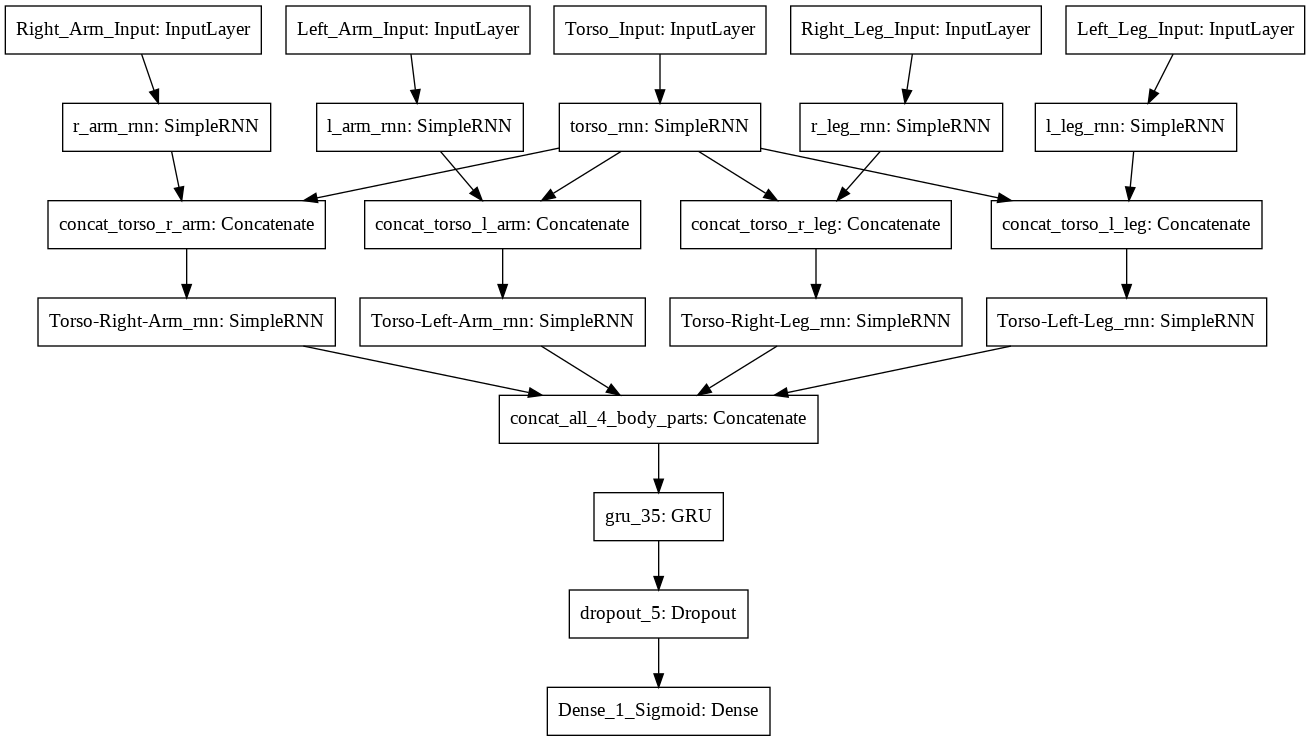

In [0]:
from keras.utils import plot_model

mod = build_model_rnn()
mod.summary()
# plot_model(mod, )
plot_model(mod, show_shapes=False)
# plot_model(mod, show_shapes=True, show_layer_names=True,to_file='model_shapes_names_r.png')

In [0]:
from keras import models
from keras import layers
from keras import optimizers
from keras.layers import Bidirectional
import keras 
#Build the model function. 
from keras import models
from keras import layers
from keras.models import Model

def build_model_hbl():
    i = keras.initializers.RandomNormal(mean=0.0, stddev=.025, seed=None)
    glo = keras.initializers.glorot_normal(seed=1)
    he = keras.initializers.he_normal(seed=1)
    input_torso = layers.Input(shape=(120,12), name='Torso_Input')
    input_left_arm = layers.Input(shape=(120,6), name = 'Left_Arm_Input')
    input_right_arm = layers.Input(shape=(120,6), name = 'Right_Arm_Input')
    input_right_leg = layers.Input(shape=(120,12), name = 'Right_Leg_Input')
    input_left_leg = layers.Input(shape=(120,12), name = 'Left_Leg_Input')

    torso_branch = layers.SimpleRNN(12, activation='tanh', return_sequences = True, kernel_initializer=glo, name = 'lstm1') (input_torso)
    r_arm_branch = layers.SimpleRNN(12, activation='tanh', return_sequences = True, kernel_initializer=glo, name='lstm2') (input_right_arm)
    l_arm_branch = layers.SimpleRNN(12, activation='tanh', return_sequences = True, kernel_initializer=glo, name='lstm3') (input_left_arm)
    l_leg_branch = layers.SimpleRNN(12, activation='tanh', return_sequences = True, kernel_initializer=glo, name='lstm4') (input_left_leg)
    r_leg_branch = layers.SimpleRNN(12, activation='tanh', return_sequences = True, kernel_initializer=glo, name='lstm5') (input_right_leg)

    torso_r_arm_con = layers.concatenate([torso_branch, r_arm_branch], axis=-1, name='concat1')
    torso_l_arm_con = layers.concatenate([torso_branch, l_arm_branch], axis=-1, name='concat2')
    torso_r_leg_con = layers.concatenate([torso_branch, r_leg_branch], axis=-1, name='concat3')
    torso_l_leg_con = layers.concatenate([torso_branch, l_leg_branch], axis=-1, name='concat4')

    torso_r_arm_out = layers.SimpleRNN(30, activation='tanh', return_sequences = True, kernel_initializer=glo, name='Torso-Right-Arm') (torso_r_arm_con)
    torso_l_arm_out = layers.SimpleRNN(30, activation='tanh', return_sequences = True, kernel_initializer=glo, name='Torso-Left-Arm') (torso_l_arm_con)
    torso_r_leg_out = layers.SimpleRNN(30, activation='tanh', return_sequences = True, kernel_initializer=glo, name='Torso-Right-Leg') (torso_r_leg_con)
    torso_l_leg_out = layers.SimpleRNN(30, activation='tanh', return_sequences = True, kernel_initializer=glo, name='Torso-Left-Leg') (torso_l_leg_con)

    all_con = layers.concatenate([torso_r_arm_out, torso_l_arm_out, torso_r_leg_out, torso_l_leg_out], name='concat5')

    all_out_1 = layers.LSTM(100, activation='relu', kernel_initializer=he, return_sequences = False) (all_con)
    # all_out_2 = layers.Dense(100, activation='relu')(all_out_1)
    all_out_3 = layers.Dense(1, activation='sigmoid')(all_out_1)
    
    model = Model(inputs=[input_torso, input_left_arm, input_right_arm, input_left_leg, input_right_leg], outputs=all_out_3)
    sgd = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.5, nesterov=True)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

def build_model_rnn():
    i = keras.initializers.RandomNormal(mean=0.0, stddev=.025, seed=None)
    glo = keras.initializers.glorot_normal(seed=1)
    he = keras.initializers.he_normal(seed=1)

    l1 = keras.regularizers.l1(0.01)
    l2 = keras.regularizers.l2(0.01)
    l1_l2 = keras.regularizers.l1_l2(l1=0.01, l2=0.01)

    zero = keras.initializers.Zeros()

    input_torso = layers.Input(shape=(120,12), name='Torso_Input')
    input_left_arm = layers.Input(shape=(120,6), name = 'Left_Arm_Input')
    input_right_arm = layers.Input(shape=(120,6), name = 'Right_Arm_Input')
    input_right_leg = layers.Input(shape=(120,12), name = 'Right_Leg_Input')
    input_left_leg = layers.Input(shape=(120,12), name = 'Left_Leg_Input')

    torso_branch = layers.SimpleRNN(12, activation='tanh', return_sequences = True, kernel_initializer=glo, bias_initializer = zero, name = 'torso_rnn') (input_torso)
    r_arm_branch = layers.SimpleRNN(12, activation='tanh', return_sequences = True, kernel_initializer=glo, bias_initializer = zero, name='r_arm_rnn') (input_right_arm)
    l_arm_branch = layers.SimpleRNN(12, activation='tanh', return_sequences = True, kernel_initializer=glo, bias_initializer = zero, name='l_arm_rnn') (input_left_arm)
    l_leg_branch = layers.SimpleRNN(12, activation='tanh', return_sequences = True, kernel_initializer=glo, bias_initializer = zero, name='l_leg_rnn') (input_left_leg)
    r_leg_branch = layers.SimpleRNN(12, activation='tanh', return_sequences = True, kernel_initializer=glo, bias_initializer = zero, name='r_leg_rnn') (input_right_leg)

    torso_r_arm_con = layers.concatenate([torso_branch, r_arm_branch], axis=-1, name='concat_torso_r_arm')
    torso_l_arm_con = layers.concatenate([torso_branch, l_arm_branch], axis=-1, name='concat_torso_l_arm')
    torso_r_leg_con = layers.concatenate([torso_branch, r_leg_branch], axis=-1, name='concat_torso_r_leg')
    torso_l_leg_con = layers.concatenate([torso_branch, l_leg_branch], axis=-1, name='concat_torso_l_leg')

    torso_r_arm_out = layers.SimpleRNN(30, activation='tanh', return_sequences = True, kernel_initializer=glo, bias_initializer = zero, name='Torso-Right-Arm_rnn') (torso_r_arm_con)
    torso_l_arm_out = layers.SimpleRNN(30, activation='tanh', return_sequences = True, kernel_initializer=glo, bias_initializer = zero, name='Torso-Left-Arm_rnn') (torso_l_arm_con)
    torso_r_leg_out = layers.SimpleRNN(30, activation='tanh', return_sequences = True, kernel_initializer=glo, bias_initializer = zero, name='Torso-Right-Leg_rnn') (torso_r_leg_con)
    torso_l_leg_out = layers.SimpleRNN(30, activation='tanh', return_sequences = True, kernel_initializer=glo, bias_initializer = zero, name='Torso-Left-Leg_rnn') (torso_l_leg_con)

    all_con = layers.concatenate([torso_r_arm_out, torso_l_arm_out, torso_r_leg_out, torso_l_leg_out], name='concat_all_4_body_parts')
    # bias_initializer=zero,
    # bias_regularizer = l1,
    # activity_regularizer=l1
    # kernel_initializer=he, kernel_regularizer=l2, 
    # kernel_regularizer=l1,    
    all_out_1 = layers.GRU(128, activation='relu', return_sequences=False, kernel_initializer=glo)(all_con)
    all_out_2 = layers.Dropout(.3) (all_out_1)
    # all_out_1 = layers.LSTM(100, activation='relu', return_sequences = False, name='Final_LSTM') (all_con)
    # all_out_2 = layers.BatchNormalization(name='batch_normalization')(all_out_1)
    # all_out_2 = layers.Dense(100, activation='relu')(all_out_1)
    all_out_3 = layers.Dense(1, activation='sigmoid', name='Dense_1_Sigmoid')(all_out_2)
    
    model = Model(inputs=[input_torso, input_left_arm, input_right_arm, input_left_leg, input_right_leg], outputs=all_out_3)
    # sgd = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.5, nesterov=True)
    # adam_1 = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


#Trying to get more consistant training...
def build_model_bi_gru():
    i = keras.initializers.RandomNormal(mean=0.0, stddev=.025, seed=None)
    glo = keras.initializers.glorot_normal(seed=1)
    he = keras.initializers.he_normal(seed=1)

    l1 = keras.regularizers.l1(0.01)
    l2 = keras.regularizers.l2(0.01)
    l1_l2 = keras.regularizers.l1_l2(l1=0.01, l2=0.01)

    zero = keras.initializers.Zeros()

    input_torso = layers.Input(shape=(120,12), name='Torso_Input')
    input_left_arm = layers.Input(shape=(120,6), name = 'Left_Arm_Input')
    input_right_arm = layers.Input(shape=(120,6), name = 'Right_Arm_Input')
    input_right_leg = layers.Input(shape=(120,12), name = 'Right_Leg_Input')
    input_left_leg = layers.Input(shape=(120,12), name = 'Left_Leg_Input')

    torso_branch = Bidirectional(layers.SimpleRNN(12, activation='tanh', return_sequences = True, kernel_initializer=glo, bias_initializer = zero, name = 'torso_gru')) (input_torso)
    r_arm_branch = Bidirectional(layers.SimpleRNN(12, activation='tanh', return_sequences = True, kernel_initializer=glo, bias_initializer = zero, name='r_arm_gru')) (input_right_arm)
    l_arm_branch = Bidirectional(layers.SimpleRNN(12, activation='tanh', return_sequences = True, kernel_initializer=glo, bias_initializer = zero, name='l_arm_gru')) (input_left_arm)
    l_leg_branch = Bidirectional(layers.SimpleRNN(12, activation='tanh', return_sequences = True, kernel_initializer=glo, bias_initializer = zero, name='l_leg_gru')) (input_left_leg)
    r_leg_branch = Bidirectional(layers.SimpleRNN(12, activation='tanh', return_sequences = True, kernel_initializer=glo, bias_initializer = zero, name='r_leg_gru')) (input_right_leg)

    torso_r_arm_con = layers.concatenate([torso_branch, r_arm_branch], axis=-1, name='concat_torso_r_arm')
    torso_l_arm_con = layers.concatenate([torso_branch, l_arm_branch], axis=-1, name='concat_torso_l_arm')
    torso_r_leg_con = layers.concatenate([torso_branch, r_leg_branch], axis=-1, name='concat_torso_r_leg')
    torso_l_leg_con = layers.concatenate([torso_branch, l_leg_branch], axis=-1, name='concat_torso_l_leg')

    torso_r_arm_out = Bidirectional(layers.SimpleRNN(30, activation='tanh', return_sequences = True, kernel_initializer=glo, bias_initializer = zero, name='Torso-Right-Arm_gru')) (torso_r_arm_con)
    torso_l_arm_out = Bidirectional(layers.SimpleRNN(30, activation='tanh', return_sequences = True, kernel_initializer=glo, bias_initializer = zero, name='Torso-Left-Arm_gru')) (torso_l_arm_con)
    torso_r_leg_out = Bidirectional(layers.SimpleRNN(30, activation='tanh', return_sequences = True, kernel_initializer=glo, bias_initializer = zero, name='Torso-Right-Leg_gru')) (torso_r_leg_con)
    torso_l_leg_out = Bidirectional(layers.SimpleRNN(30, activation='tanh', return_sequences = True, kernel_initializer=glo, bias_initializer = zero, name='Torso-Left-Leg_gru')) (torso_l_leg_con)

    all_con = layers.concatenate([torso_r_arm_out, torso_l_arm_out, torso_r_leg_out, torso_l_leg_out], name='concat_all_4_body_parts')
    # bias_initializer=zero,
    # bias_regularizer = l1,
    # activity_regularizer=l1
    # kernel_initializer=he, kernel_regularizer=l2, 
    # kernel_regularizer=l1, 

    all_out_1 = Bidirectional(layers.GRU(128, activation='relu', return_sequences=False, kernel_initializer=glo)(all_con))
    # all_out_1 = layers.LSTM(100, activation='relu', return_sequences = False, name='Final_LSTM') (all_con)
    # all_out_2 = layers.BatchNormalization(name='batch_normalization')(all_out_1)
    # all_out_2 = layers.Dense(100, activation='relu')(all_out_1)
    all_out_3 = layers.Dense(1, activation='sigmoid', name='Dense_1_Sigmoid')(all_out_1)
    
    model = Model(inputs=[input_torso, input_left_arm, input_right_arm, input_left_leg, input_right_leg], outputs=all_out_3)
    # sgd = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.5, nesterov=True)

    adam_1 = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam_1, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

def build_model_gru():
    i = keras.initializers.RandomNormal(mean=0.0, stddev=.025, seed=None)
    glo = keras.initializers.glorot_normal(seed=1)
    he = keras.initializers.he_normal(seed=1)

    l1 = keras.regularizers.l1(0.01)
    l2 = keras.regularizers.l2(0.01)
    l1_l2 = keras.regularizers.l1_l2(l1=0.01, l2=0.01)

    zero = keras.initializers.Zeros()

    input_torso = layers.Input(shape=(120,12), name='Torso_Input')
    input_left_arm = layers.Input(shape=(120,6), name = 'Left_Arm_Input')
    input_right_arm = layers.Input(shape=(120,6), name = 'Right_Arm_Input')
    input_right_leg = layers.Input(shape=(120,12), name = 'Right_Leg_Input')
    input_left_leg = layers.Input(shape=(120,12), name = 'Left_Leg_Input')

    torso_branch = layers.GRU(16, activation='relu', return_sequences = True, kernel_initializer=glo, bias_initializer = zero, name = 'torso_gru') (input_torso)
    r_arm_branch = layers.GRU(16, activation='relu', return_sequences = True, kernel_initializer=glo, bias_initializer = zero, name='r_arm_gru') (input_right_arm)
    l_arm_branch = layers.GRU(16, activation='relu', return_sequences = True, kernel_initializer=glo, bias_initializer = zero, name='l_arm_gru') (input_left_arm)
    l_leg_branch = layers.GRU(16, activation='relu', return_sequences = True, kernel_initializer=glo, bias_initializer = zero, name='l_leg_gru') (input_left_leg)
    r_leg_branch = layers.GRU(16, activation='relu', return_sequences = True, kernel_initializer=glo, bias_initializer = zero, name='r_leg_gru') (input_right_leg)

    torso_r_arm_con = layers.concatenate([torso_branch, r_arm_branch], axis=-1, name='concat_torso_r_arm')
    torso_l_arm_con = layers.concatenate([torso_branch, l_arm_branch], axis=-1, name='concat_torso_l_arm')
    torso_r_leg_con = layers.concatenate([torso_branch, r_leg_branch], axis=-1, name='concat_torso_r_leg')
    torso_l_leg_con = layers.concatenate([torso_branch, l_leg_branch], axis=-1, name='concat_torso_l_leg')

    torso_r_arm_out = layers.GRU(32, activation='relu', return_sequences = True, kernel_initializer=glo, bias_initializer = zero, name='Torso-Right-Arm_gru') (torso_r_arm_con)
    torso_l_arm_out = layers.GRU(32, activation='relu', return_sequences = True, kernel_initializer=glo, bias_initializer = zero, name='Torso-Left-Arm_gru') (torso_l_arm_con)
    torso_r_leg_out = layers.GRU(32, activation='relu', return_sequences = True, kernel_initializer=glo, bias_initializer = zero, name='Torso-Right-Leg_gru') (torso_r_leg_con)
    torso_l_leg_out = layers.GRU(32, activation='relu', return_sequences = True, kernel_initializer=glo, bias_initializer = zero, name='Torso-Left-Leg_gru') (torso_l_leg_con)

    all_con = layers.concatenate([torso_r_arm_out, torso_l_arm_out, torso_r_leg_out, torso_l_leg_out], name='concat_all_4_body_parts')
    # bias_initializer=zero,
    # bias_regularizer = l1,
    # activity_regularizer=l1
    # kernel_initializer=he, kernel_regularizer=l2, 
    # kernel_regularizer=l1, 

    all_out_1 = layers.GRU(128, activation='relu', return_sequences=False, kernel_initializer=glo) (all_con)
    # all_out_1 = layers.LSTM(100, activation='relu', return_sequences = False, name='Final_LSTM') (all_con)
    # all_out_2 = layers.BatchNormalization(name='batch_normalization')(all_out_1)
    # all_out_2 = layers.Dense(100, activation='relu')(all_out_1)
    all_out_3 = layers.Dense(1, activation='sigmoid', name='Dense_1_Sigmoid')(all_out_1)
    
    model = Model(inputs=[input_torso, input_left_arm, input_right_arm, input_left_leg, input_right_leg], outputs=all_out_3)
    # sgd = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.5, nesterov=True)

    adam_1 = optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam_1, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

## Train


In [0]:
!pip show tensorflow
!pip show keras

In [0]:
import numpy as np
import random 
import os 

#For no more tensor flow warnings. 
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

#Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#Get good ratio of training/validation/testing data. 
import os 
import random
import numpy as np
print(len(os.listdir('gdrive/My Drive/Seizure2/all_data_hd_npy/')))

data_files = os.listdir('gdrive/My Drive/Seizure2/all_data_hd_npy/')

data = {}
labels = {}

for _name in data_files:
    if 'Seizure' in _name:
        labels[_name] = 1
    else:
        labels[_name] = 0

random.seed(4)
random.shuffle(data_files)

num_seizure_files = len([ _name for _name in data_files if 'Seizure' in _name])

train_index = int(len(data_files) * .8)
validation_index = int(train_index * .15)

data['test'] = np.array(data_files[train_index:])
data['validation'] = np.array(data_files[:validation_index])
data['train'] = np.array(data_files[validation_index:train_index])

print('Number of Seizure data in dataset: ', num_seizure_files)
print('Total number of files: ', len(data_files))
print('Percentage of Seizure data in dataset: {} %'.format(num_seizure_files/len(data_files)*100))

num_seizure_files_train = len([ _name for _name in data['train'] if 'Seizure' in _name])
num_seizure_files_test = len([ _name for _name in data['test'] if 'Seizure' in _name])
num_seizure_files_validation = len([ _name for _name in data['validation'] if 'Seizure' in _name])

print('Number of training samples: ', len(data['train']))
print('Number of testing samples: ', len(data['test']))
print('Number of validation samples: ', len(data['validation']))
print('Total: ', len(data['train']) + len(data['test']) + len(data['validation']))

print('Percentage of Seizure data in training dataset: {} %'.format(num_seizure_files_train/len(data['train'])*100))
print('Percentage of Seizure data in testing dataset: {} %'.format(num_seizure_files_test/len(data['test'])*100))
print('Percentage of Seizure data in validation dataset: {} %'.format(num_seizure_files_validation/len(data['validation'])*100))


3124
Number of Seizure data in dataset:  922
Total number of files:  3124
Percentage of Seizure data in dataset: 29.513444302176694 %
Number of training samples:  2125
Number of testing samples:  625
Number of validation samples:  374
Total:  3124
Percentage of Seizure data in training dataset: 30.44705882352941 %
Percentage of Seizure data in testing dataset: 26.88 %
Percentage of Seizure data in validation dataset: 28.609625668449194 %


In [0]:
from keras import models
from keras import layers
from keras import optimizers
import os
import numpy as np
import random
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

#Hyper-parameters 

batch_size = 64
num_epochs = 50
import numpy as np

#Create dictionary entries of all data. 
py_train_path = 'gdrive/My Drive/Seizure2/all_data_hd_npy/'


params ={'location': py_train_path,
        'dim': (120, 12, 5),
          'batch_size': batch_size,
          'n_classes': 1,
          'n_channels': 1,
          'shuffle': True}

validation_params ={'location': py_train_path,
        'dim': (120, 12, 5),
          'batch_size': len(data['validation']),
          'n_classes': 1,
          'n_channels': 1,
          'shuffle': True}
        
test_params = {'location': py_train_path,
        'dim': (120, 12, 5),
          'batch_size': len(data['test']),
          'n_classes': 1,
          'n_channels': 1,
          'shuffle': True}
testing_generator = DataGenerator(data['test'], labels, **test_params)
training_generator = DataGenerator(data['train'], labels, **params)
validating_generator = DataGenerator(data['validation'], labels, **validation_params)

histories = []
# for i in range(3):
# model = build_model_gru()
model = build_model_rnn()
filepath="gru-do-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
history = model.fit_generator(generator=training_generator, validation_data=validating_generator, callbacks = callbacks_list, validation_freq = 1, use_multiprocessing=True, workers=8, epochs=num_epochs,verbose=1)
histories.append(history)



Epoch 1/50
33/33 [==============================] - 24s 713ms/step - loss: 0.5150 - accuracy: 0.7420 - val_loss: 0.3577 - val_accuracy: 0.8048

Epoch 00001: val_loss improved from inf to 0.35772, saving model to gru-do-01-0.36.hdf5
Epoch 2/50
33/33 [==============================] - 18s 557ms/step - loss: 0.3508 - accuracy: 0.8116 - val_loss: 0.2896 - val_accuracy: 0.8396

Epoch 00002: val_loss improved from 0.35772 to 0.28957, saving model to gru-do-02-0.29.hdf5
Epoch 3/50
33/33 [==============================] - 19s 563ms/step - loss: 0.3102 - accuracy: 0.8395 - val_loss: 0.3102 - val_accuracy: 0.8396

Epoch 00003: val_loss did not improve from 0.28957
Epoch 4/50
33/33 [==============================] - 19s 571ms/step - loss: 0.2995 - accuracy: 0.8608 - val_loss: 0.2451 - val_accuracy: 0.8930

Epoch 00004: val_loss improved from 0.28957 to 0.24514, saving model to gru-do-04-0.25.hdf5
Epoch 5/50
33/33 [==============================] - 19s 563ms/step - loss: 0.2869 - accuracy: 0.8641 

In [0]:
!rm *.hdf5
# !pip show tensorflow

val_loss
val_accuracy
loss
accuracy


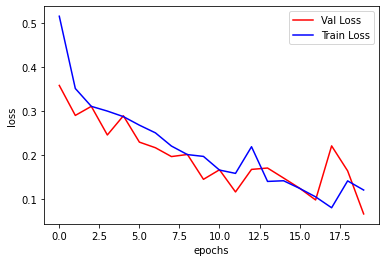

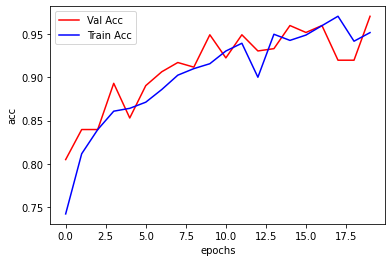

In [0]:
import matplotlib.pyplot as plt
for h in history.history:
    print(h)

history = histories[0]
plt.figure()
val_loss = history.history['val_loss']
loss = history.history['loss']
plt.xlabel('epochs')
plt.ylabel('loss')
num_epochs = range(20)

plt.plot(num_epochs, val_loss[:len(num_epochs)], 'r', label = 'Val Loss')
plt.plot( num_epochs, loss[:len(num_epochs)], 'b', label = 'Train Loss')
plt.legend()
plt.show()

val_loss = history.history['val_accuracy']
loss = history.history['accuracy']
plt.xlabel('epochs')
plt.ylabel('acc')
num_epochs = range(20)

plt.plot(num_epochs, val_loss[:len(num_epochs)], 'r', label = 'Val Acc')
plt.plot( num_epochs, loss[:len(num_epochs)], 'b', label = 'Train Acc')
plt.legend()
plt.show()


In [0]:
j_model = build_model_rnn()
j_model.load_weights('gru-do-49-.01.hdf5')

py_train_path = 'gdrive/My Drive/Seizure2/all_data_hd_npy/'
test_params = {'location': py_train_path,
        'dim': (120, 12, 5),
          'batch_size': len(data['test']),
          'n_classes': 1,
          'n_channels': 1,
          'shuffle': True}
testing_generator = DataGenerator(data['test'], labels, **test_params)
j_model.evaluate_generator(generator=testing_generator, steps=None, callbacks=None, max_queue_size=10, workers=0, use_multiprocessing=False, verbose=1)

OSError: ignored

[0.13054610788822174, 0.9391999840736389]


## Fit the model

In [0]:
import numpy as np
import random 
import os 

#For no more tensor flow warnings. 
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

#Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')


# Load Model

In [0]:
import numpy as np
import random 
import os 

#For no more tensor flow warnings. 
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

#Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')
from keras import models

#Load past model and evaluate the model
model_path = 'gdrive/My Drive/Seizure DL/OverSample_2/weights.18.hdf5'
train_data_path = 'gdrive/My Drive/Seizure DL/OverSample_2/Train/'
test_data_path = 'gdrive/My Drive/Seizure DL/OverSample_2/Test/'

#Load model 
dependencies = {
    'f1_score': f1_score,
    'precision_m': precision_m,
    'recall_m': recall_m
}
# model = keras.models.load_model(self.output_directory + 'best_model.hdf5', custom_objects=dependencies)
root = 'gdrive/My Drive/Seizure DL/OverSample_2/'
# model_paths = ['weights.161.hdf5','weights.162.hdf5','weights.211.hdf5']
model_paths = ['weights.340.hdf5']

for mp in model_paths:
    print('\n')
    print(mp)
    # my_model = build_model_3()
    my_model = load_model(root+mp, custom_objects=dependencies)
    #Load testing data
    (train_x, train_y, train_names), (test_x, test_y, test_names) = load_data(train_location=train_data_path, test_location=test_data_path, get_name=True)


    h = my_model.evaluate(test_x, test_y, verbose=1)

    for i in range(len(test_y)):
        pred = my_model.predict(x=test_x[i].reshape(1,80,50))
        print(test_names[i] + ' : ' + str(pred))

    print('test output:')
    print(h)


# Visualizing Landmarks 


(2, 120, 12)
(2, 120, 6)
(2, 120, 6)
(2, 120, 12)
(2, 120, 12)
2
['jj-vid_2.npy' 'jj-vid_1.npy']
full shape:
(120, 50)


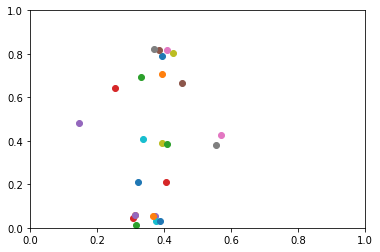

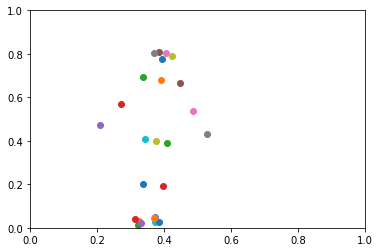

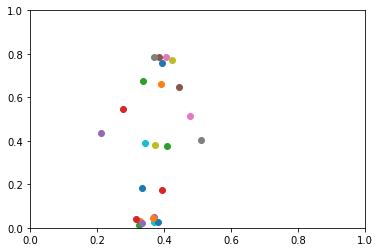

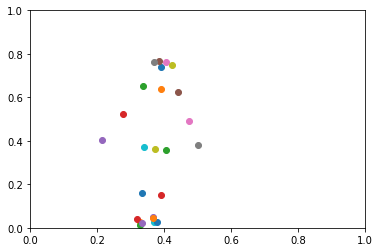

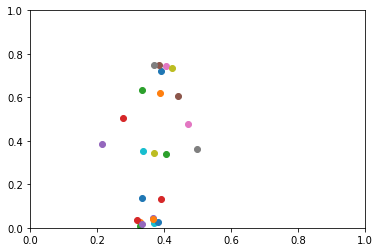

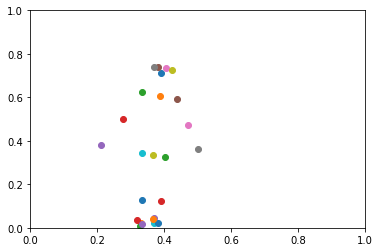

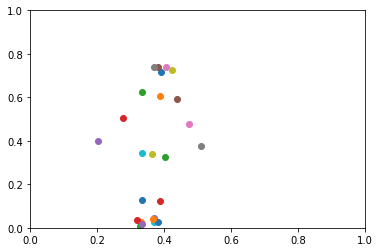

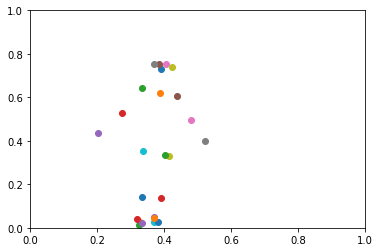

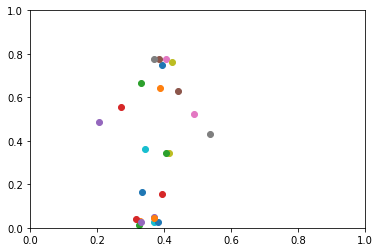

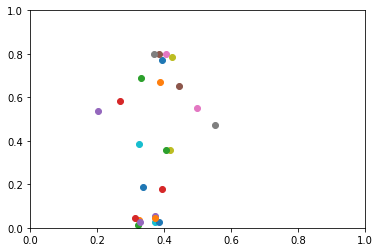

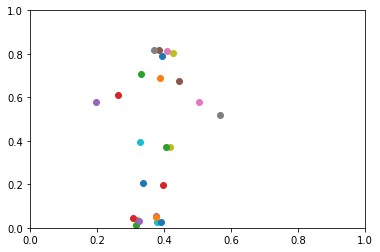

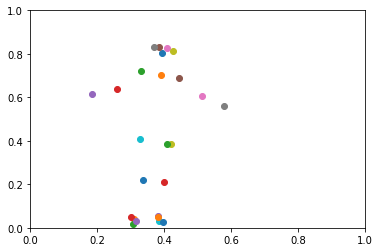

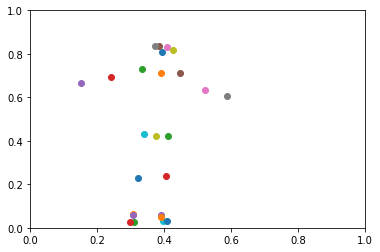

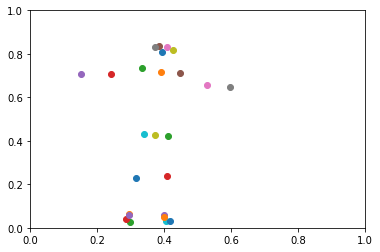

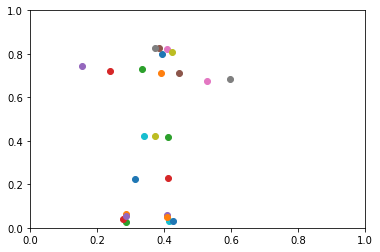

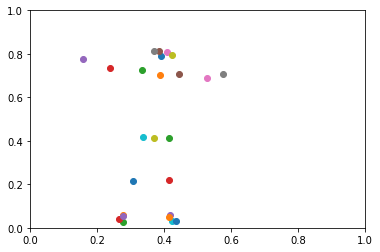

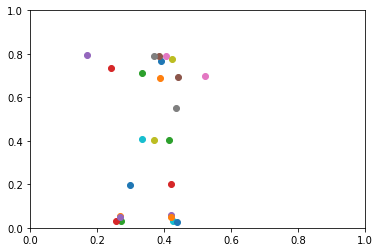

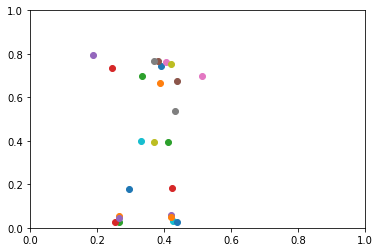

KeyboardInterrupt: ignored

In [0]:
from keras import models
from keras import layers
from keras import optimizers
import os
import numpy as np
import random
#Create dictionary entries of all data. 
py_train_path = '/content/jj_npy/'

partition = {}
partition['train'] = np.array(os.listdir(py_train_path))


labels = {}
for p in partition:
    for item in partition[p]:
        if 'seizure' in item:
            labels[item] = 1
        else:
            labels[item] = 0


params ={'location': py_train_path,
        'dim': (120, 12, 5),
          'batch_size': batch_size,
          'n_classes': 1,
          'n_channels': 1,
          'shuffle': True}

training_generator = DataGenerator(partial_train_data, labels, **params)

#[torso, right_arm, left_arm, right_leg, left_leg]
[t, r_a, l_a, r_l, l_l], y = training_generator.tester(partial_train_data[:16])
print(t.shape)
print(r_a.shape)
print(l_a.shape)
print(r_l.shape)
print(l_l.shape)

#Full body 'video'
print(len(partial_train_data))
print(partial_train_data)
f = np.load(py_train_path + partial_train_data[0])
print('full shape:')
print(f.shape)

# _t10 = t[0] 
_t10 = f

# print(_t10.shape)
plt.figure()
for i in range(0, len(_t10), 1):
    for j in range(0,len(_t10[0]),2):
        plt.xlim(0, 1)
        plt.ylim((0, 1))
        plt.scatter(_t10[i][j], _t10[i][j+1])
    

    plt.pause(.0001)

In [0]:
def load_data(list_IDs_temp=None, labels=None, location_data = ""):
        dim1 = len(list_IDs_temp)

        y = np.empty(dim1, dtype=int)
        r_arm_data = np.empty((dim1, 120, 6))
        l_arm_data = np.empty((dim1, 120, 6))
        r_leg_data = np.empty((dim1, 120, 12))
        l_leg_data = np.empty((dim1, 120, 12))
        torso_data = np.empty((dim1, 120, 12))
        # X = np.empty((self.batch_size), dtype=np.ndarray)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            opened_data = np.load(location_data + ID) 
            #(120, 50)
                
            _temp_r_arm_data = np.empty((120,6))
            _temp_l_arm_data = np.empty((120,6))
            _temp_r_leg_data = np.empty((120, 12))
            _temp_l_leg_data = np.empty((120, 12))
            _temp_torso_data = np.empty((120, 12))


            for j,mat in enumerate(opened_data):
                #iterate 120 timestamps
                mult = 2
                #(120, 6) pad with 6 zeros 
                _temp_r_arm_data[j,] = np.array([mat[2*mult], mat[mult*2+1], 
                                          mat[3*mult], mat[mult*3+1],
                                          mat[4*mult], mat[mult*4+1]])
                                        #   0, 0, 
                                        #   0, 0, 
                                        #   0, 0])
                
                #(120, 6) pad with 6 zeros
                _temp_l_arm_data[j,] = np.array([mat[5*mult], mat[mult*5+1], 
                                          mat[6*mult], mat[mult*6+1],
                                          mat[7*mult], mat[mult*7+1]])
                                        #   ,
                                        #   0, 0, 
                                        #   0, 0,
                                        #   0, 0])
                
                #(120, 12)
                _temp_r_leg_data[j,] = np.array([mat[9*mult], mat[mult*9+1], 
                                          mat[10*mult], mat[mult*10+1],
                                          mat[11*mult], mat[mult*11+1],
                                          mat[22*mult], mat[mult*22+1], 
                                          mat[23*mult], mat[mult*23+1],
                                          mat[24*mult], mat[mult*24+1]])
                #(120, 12)
                _temp_l_leg_data[j,] = np.array([mat[12*mult], mat[mult*12+1], 
                                          mat[13*mult], mat[mult*13+1],
                                          mat[14*mult], mat[mult*14+1],
                                          mat[19*mult], mat[mult*19+1], 
                                          mat[20*mult], mat[mult*20+1],
                                          mat[21*mult], mat[mult*21+1]]) 
                
                #(120, 12)
                _temp_torso_data[j,] = np.array([mat[1*mult], mat[mult*1+1], 
                                          mat[2*mult], mat[mult*2+1],
                                          mat[5*mult], mat[mult*5+1],
                                          mat[8*mult], mat[mult*8+1], 
                                          mat[9*mult], mat[mult*9+1],
                                          mat[12*mult], mat[mult*12+1]])

            r_arm_data[i,] = _temp_r_arm_data
            l_arm_data[i,] = _temp_l_arm_data
            r_leg_data[i,] = _temp_r_leg_data
            l_leg_data[i,] = _temp_l_leg_data
            torso_data[i,] = _temp_torso_data
            # Store class
            y[i] = labels[ID]

        return [torso_data, l_arm_data, r_arm_data, l_leg_data, r_leg_data], y

In [0]:
#More testing models.
root = '/content/t_dataa/'
names = os.listdir(root)

labels = {}
for _name in names:
    if 'Seizure' in _name: 
        labels[_name] = 1
    else:
        labels[_name] = 0

X, y = load_data(location_data=root, list_IDs_temp=names, labels = labels)

from keras.models import load_model
final_model = load_model('/content/rnn-imp.hdf5')

for n in names:
    x, y = load_data(location_data=root, list_IDs_temp=[n], labels = labels)
    p = final_model.predict(x)
    print(n, ':', p)


In [0]:
!rm *.hdf5